In [1]:
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import matplotlib.pyplot as plt

In [2]:
audio = '/content/drive/MyDrive/genres/blues/blues.00010.wav'

In [3]:
data, sr = librosa.load(audio)

In [6]:
print(data, sr)

[0.12014771 0.14956665 0.10458374 ... 0.01803589 0.01541138 0.01037598] 22050


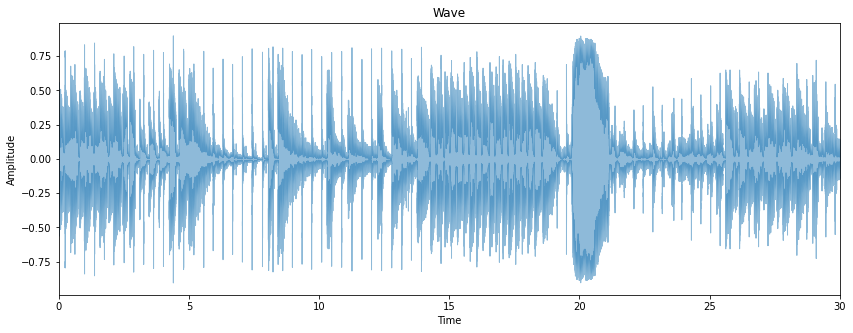

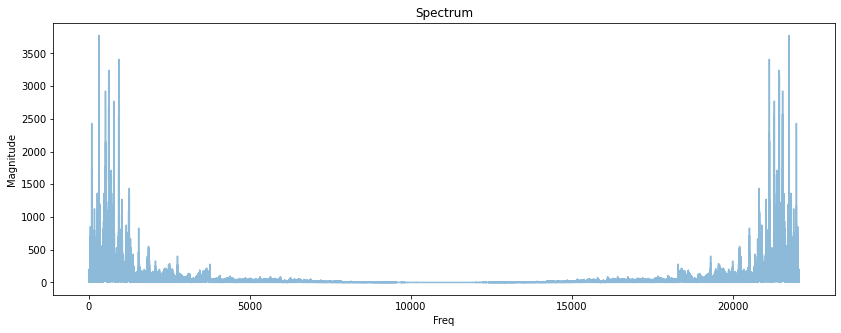

In [11]:
fig_size=(14,5)
plt.figure(figsize=fig_size)
librosa.display.waveplot(data,sr,alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Wave")

fft=np.fft.fft(data)
spec=np.abs(fft)
freq=np.linspace(0,sr,len(spec))

plt.figure(figsize=fig_size)
plt.plot(freq, spec ,alpha=0.5)
plt.xlabel("Freq")
plt.ylabel("Magnitude")
plt.title("Spectrum")
plt.show()

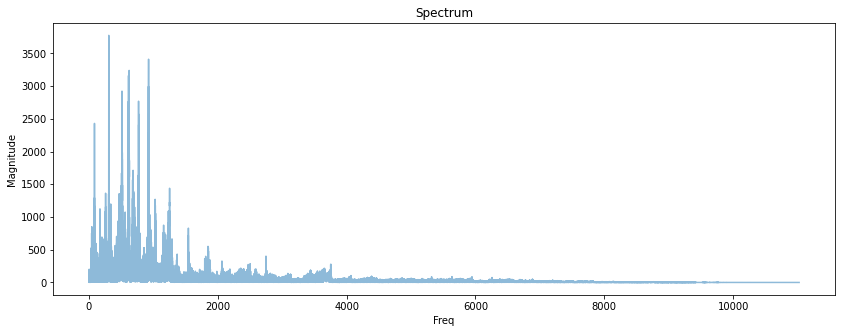

In [13]:
left_spec=spec[:int(len(spec)/2)]
left_freq=freq[:int(len(spec)/2)]
plt.figure(figsize=fig_size)
plt.plot(left_freq,left_spec,alpha=0.5)
plt.xlabel("Freq")
plt.ylabel("Magnitude")
plt.title("Spectrum")
plt.show()

In [14]:
hop_length=512
n_fft=2048

In [15]:
stft=librosa.stft(data,n_fft=n_fft,hop_length=hop_length)
spectrogram=np.abs(stft)

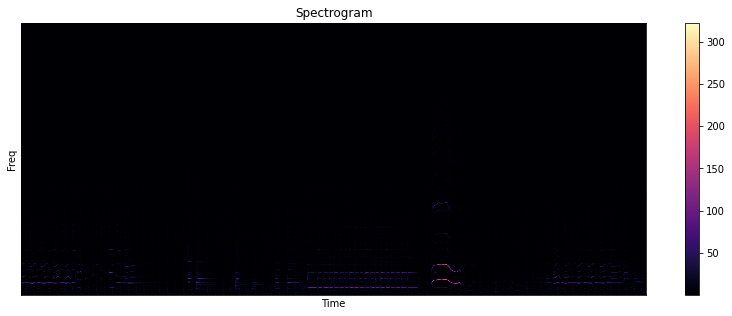

In [19]:
plt.figure(figsize=fig_size)
librosa.display.specshow(spectrogram,sr=sr,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

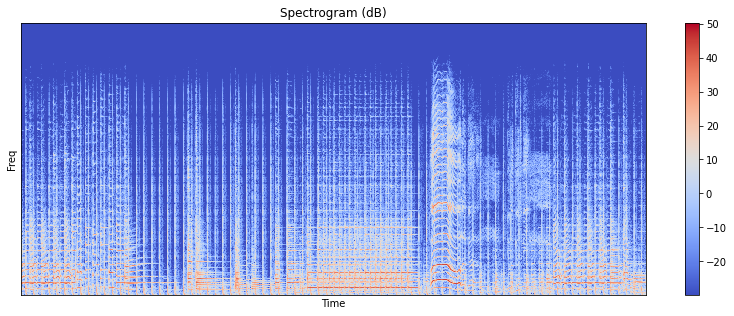

In [22]:
log_spect=librosa.amplitude_to_db(spectrogram)
plt.figure(figsize=fig_size)
librosa.display.specshow(log_spect,sr=sr,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.colorbar()
plt.title("Spectrogram (dB)")
plt.show()

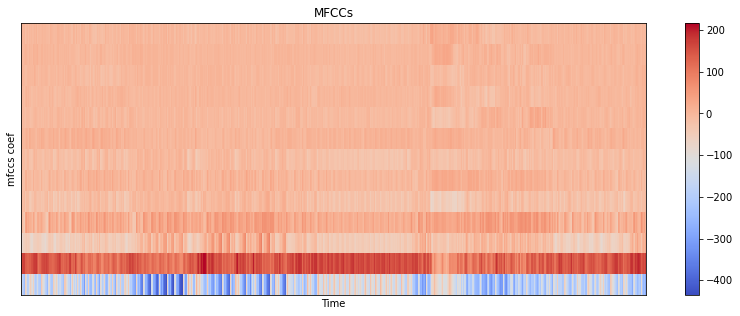

In [24]:
mfccs=librosa.feature.mfcc(data,sr,n_fft=n_fft,hop_length=hop_length,n_mfcc=13)
plt.figure(figsize=fig_size)
librosa.display.specshow(mfccs,sr=sr,hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("mfccs coef")
plt.colorbar()
plt.title("MFCCs")
plt.show()

In [25]:
import json
import os
import math


In [38]:
audio_path="/content/drive/MyDrive/genres"
json_path="/content/sample_data/data.json"
sample_rate=22050
duration=30
sample_per_track=sr*duration

In [43]:
def save_mfcc(audio_path,json_path,num_mfcc=13,n_nfft=2048,hop_length=512,num_segments=5):
    datas={
         "mapping":[],
         "labels":[],
         "mfcc":[]
    }
    samples_per_segment=int(sample_per_track / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment/hop_length)
    for i,(dirpath,dirnames,filenames) in enumerate(os.walk(audio_path)):
       if dirpath is not audio_path:
           semantic_label = dirpath.split("/")
           datas["mapping"].append(semantic_label)
           print("\nProcessing: {}".format(semantic_label))

           for j in filenames:
             file_path = os.path.join(dirpath, j)
             data, sr = librosa.load(file_path, sr=sample_rate)

             for k in range(num_segments):
               start = samples_per_segment*k
               finish = start+samples_per_segment
               mfcc = librosa.feature.mfcc(data[start:finish],sr,n_mfcc=num_mfcc,n_fft=n_fft,hop_length=hop_length)
               mfcc = mfcc.T
               if len(mfcc) == num_mfcc_vectors_per_segment:
                 datas["mfcc"].append(mfcc.tolist())
                 datas["labels"].append(i-1)
                 print("{}, segment:{}".format(file_path,k+1))


    with open(json_path,"w") as jp:
        json.dump(datas, jp, indent=4)


In [44]:
save_mfcc(audio_path, json_path, num_segments=10)

Streaming output truncated to the last 5000 lines.
/content/drive/MyDrive/genres/disco/disco.00092.wav, segment:9
/content/drive/MyDrive/genres/disco/disco.00092.wav, segment:10

Processing: ['', 'content', 'drive', 'MyDrive', 'genres', 'hiphop']
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:1
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:2
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:3
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:4
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:5
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:6
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:7
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:8
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:9
/content/drive/MyDrive/genres/hiphop/hiphop.00005.wav, segment:10
/content/drive/MyDrive/genres/hiphop/hiphop.00011.wav, segment:1
/content/drive/MyDrive/genres/hiphop/

In [45]:
import sklearn
import tensorflow
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import random

In [46]:
audiodata_path = "/content/drive/MyDrive/genres/data.json"

In [106]:
def load_data(audiodata_path):
  with open(audiodata_path, "r") as a:
    datas = json.load(a)
  X = np.array(datas["mfcc"])
  y = np.array(datas["labels"])
  print("Data successfully loaded!")
  return X,y

def plot_history(history):
  fig,axs = plt.subplots(2)
  axs[0].plot(history.history["accuracy"],label="train acc")
  axs[0].plot(history.history["val_accuracy"],label="test acc")
  axs[0].set_ylabel("Accuracy")
  axs[0].legend(loc="lower right")
  axs[0].set_title("Accuracy evaluation")

  axs[1].plot(history.history["loss"],label="train error")
  axs[1].plot(history.history["val_loss"],label="test error")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].legend(loc="upper right")
  axs[1].set_title("Error evaluation")

  plt.show()

In [107]:
X,y = load_data(audiodata_path)

Data successfully loaded!


In [122]:
X.shape

(9986, 130, 13)

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)  

In [124]:
model = keras.Sequential([

    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dense(256, activation='relu'),

    keras.layers.Dense(64, activation='relu'),

    keras.layers.Dense(10, activation='softmax')
])
     


In [125]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [126]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 1690)              0         
                                                                 
 dense_12 (Dense)            (None, 512)               865792    
                                                                 
 dense_13 (Dense)            (None, 256)               131328    
                                                                 
 dense_14 (Dense)            (None, 64)                16448     
                                                                 
 dense_15 (Dense)            (None, 10)                650       
                                                                 
Total params: 1,014,218
Trainable params: 1,014,218
Non-trainable params: 0
_________________________________________________________________


In [127]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=50)

Epoch 1/50
219/219 [==============================] - 10s 36ms/step - loss: 6.7446 - accuracy: 0.2914 - val_loss: 2.2011 - val_accuracy: 0.2877
Epoch 2/50
219/219 [==============================] - 8s 36ms/step - loss: 1.9514 - accuracy: 0.3355 - val_loss: 1.9650 - val_accuracy: 0.3204
Epoch 3/50
219/219 [==============================] - 5s 21ms/step - loss: 1.7644 - accuracy: 0.3685 - val_loss: 2.0074 - val_accuracy: 0.3234
Epoch 4/50
219/219 [==============================] - 4s 17ms/step - loss: 1.6648 - accuracy: 0.3954 - val_loss: 1.9267 - val_accuracy: 0.3708
Epoch 5/50
219/219 [==============================] - 5s 22ms/step - loss: 1.5758 - accuracy: 0.4237 - val_loss: 2.0143 - val_accuracy: 0.3344
Epoch 6/50
219/219 [==============================] - 5s 21ms/step - loss: 1.5058 - accuracy: 0.4355 - val_loss: 1.8439 - val_accuracy: 0.3732
Epoch 7/50
219/219 [==============================] - 4s 16ms/step - loss: 1.4672 - accuracy: 0.4522 - val_loss: 1.8213 - val_accuracy: 0.371

In [128]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

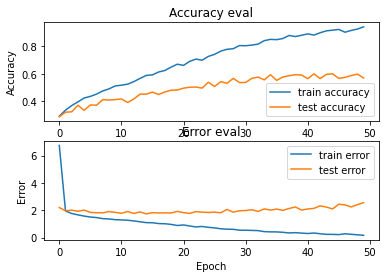

In [129]:
plot_history(history)

In [137]:
model_regularized = keras.Sequential([

    keras.layers.Flatten(input_shape=(X.shape[1], X.shape[2])),

    keras.layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(10, activation='softmax')
])

In [138]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_regularized.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [139]:
history = model_regularized.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=100)

Epoch 1/100
188/188 [==============================] - 6s 27ms/step - loss: 27.1583 - accuracy: 0.1467 - val_loss: 3.6308 - val_accuracy: 0.2599
Epoch 2/100
188/188 [==============================] - 4s 19ms/step - loss: 7.7674 - accuracy: 0.1738 - val_loss: 3.3618 - val_accuracy: 0.2315
Epoch 3/100
188/188 [==============================] - 3s 18ms/step - loss: 5.0821 - accuracy: 0.1864 - val_loss: 3.3727 - val_accuracy: 0.2135
Epoch 4/100
188/188 [==============================] - 5s 25ms/step - loss: 4.3262 - accuracy: 0.1828 - val_loss: 3.4101 - val_accuracy: 0.1698
Epoch 5/100
188/188 [==============================] - 4s 23ms/step - loss: 3.9000 - accuracy: 0.1876 - val_loss: 3.4207 - val_accuracy: 0.1654
Epoch 6/100
188/188 [==============================] - 4s 19ms/step - loss: 3.7195 - accuracy: 0.1771 - val_loss: 3.3701 - val_accuracy: 0.1866
Epoch 7/100
188/188 [==============================] - 4s 19ms/step - loss: 3.6073 - accuracy: 0.2021 - val_loss: 3.3373 - val_accuracy

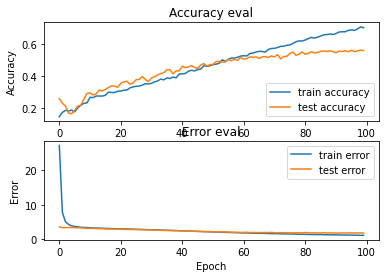

In [141]:
plot_history(history)

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

X_train = X_train[..., np.newaxis]
X_validation = X_validation[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [143]:
X_train.shape

(5991, 130, 13, 1)

In [144]:
input_shape = (X_train.shape[1], X_train.shape[2], 1)

In [145]:
model_cnn = keras.Sequential()

model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
model_cnn.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
model_cnn.add(keras.layers.BatchNormalization())

model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(64, activation='relu'))
model_cnn.add(keras.layers.Dropout(0.3))

model_cnn.add(keras.layers.Dense(10, activation='softmax'))
     

In [146]:
optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model_cnn.compile(optimizer=optimiser,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [147]:
model_cnn.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_22 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                     

In [148]:
history = model_cnn.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=100)

Epoch 1/100
188/188 [==============================] - 17s 78ms/step - loss: 2.4112 - accuracy: 0.2150 - val_loss: 1.8045 - val_accuracy: 0.3525
Epoch 2/100
188/188 [==============================] - 14s 74ms/step - loss: 1.8041 - accuracy: 0.3736 - val_loss: 1.5389 - val_accuracy: 0.4393
Epoch 3/100
188/188 [==============================] - 14s 76ms/step - loss: 1.6196 - accuracy: 0.4236 - val_loss: 1.4042 - val_accuracy: 0.4900
Epoch 4/100
188/188 [==============================] - 14s 76ms/step - loss: 1.5038 - accuracy: 0.4675 - val_loss: 1.3662 - val_accuracy: 0.4993
Epoch 5/100
188/188 [==============================] - 14s 77ms/step - loss: 1.4174 - accuracy: 0.5008 - val_loss: 1.2774 - val_accuracy: 0.5280
Epoch 6/100
188/188 [==============================] - 14s 76ms/step - loss: 1.3372 - accuracy: 0.5261 - val_loss: 1.2156 - val_accuracy: 0.5581
Epoch 7/100
188/188 [==============================] - 14s 76ms/step - loss: 1.2849 - accuracy: 0.5401 - val_loss: 1.1790 - val_ac

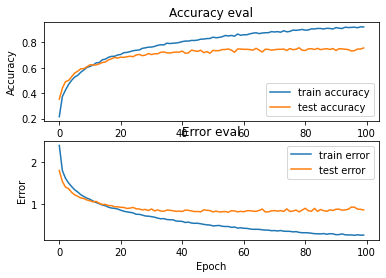

In [149]:
plot_history(history)

In [151]:
test_loss, test_acc = model_cnn.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

79/79 - 1s - loss: 0.8147 - accuracy: 0.7537 - 1s/epoch - 14ms/step

Test accuracy: 0.7537044286727905


In [152]:
model.save("MGC")

In [157]:
model.save("/content/drive/MyDrive/Models/MGC.h5")

In [158]:
X_to_predict = X_test[100]
y_to_predict = y_test[100]

In [159]:
X_to_predict.shape

(130, 13, 1)

In [160]:
print("Real Genre:", y_to_predict)

Real Genre: 4


In [161]:
X_to_predict = X_to_predict[np.newaxis, ...]

In [162]:
X_to_predict.shape

(1, 130, 13, 1)

In [163]:
prediction = model_cnn.predict(X_to_predict)

1/1 [==============================] - 0s 160ms/step


In [164]:
predicted_index = np.argmax(prediction, axis=1)
print("Predicted Genre:", int(predicted_index))

Predicted Genre: 4


In [177]:
X_to_predict = X_test[50]
y_to_predict = y_test[50]

print("Real Genre:", y_to_predict)

X_to_predict = X_to_predict[np.newaxis, ...]
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)

print("Predicted Genre:", int(predicted_index))

Real Genre: 6
1/1 [==============================] - 0s 46ms/step
Predicted Genre: 2


In [178]:
len(X_test)

2497

In [179]:
for n in range(10):

  i = random.randint(0,len(X_test))
  X_to_predict = X_test[i]
  y_to_predict = y_test[i]
  print("\nReal Genre:", y_to_predict)
  
  X_to_predict = X_to_predict[np.newaxis, ...]
  prediction = model_cnn.predict(X_to_predict)
  predicted_index = np.argmax(prediction, axis=1)
  print("Predicted Genre:", int(predicted_index))



Real Genre: 0
1/1 [==============================] - 0s 55ms/step
Predicted Genre: 0

Real Genre: 1
1/1 [==============================] - 0s 39ms/step
Predicted Genre: 1

Real Genre: 4
1/1 [==============================] - 0s 91ms/step
Predicted Genre: 4

Real Genre: 7
1/1 [==============================] - 0s 24ms/step
Predicted Genre: 7

Real Genre: 4
1/1 [==============================] - 0s 27ms/step
Predicted Genre: 4

Real Genre: 7
1/1 [==============================] - 0s 25ms/step
Predicted Genre: 7

Real Genre: 0
1/1 [==============================] - 0s 25ms/step
Predicted Genre: 4

Real Genre: 2
1/1 [==============================] - 0s 23ms/step
Predicted Genre: 2

Real Genre: 5
1/1 [==============================] - 0s 25ms/step
Predicted Genre: 5

Real Genre: 1
1/1 [==============================] - 0s 35ms/step
Predicted Genre: 1


In [180]:
def process_input(audio_file, duration):

  sample_rate = 22050
  num_mfcc = 13
  n_ftt=2048
  hop_length=512
  duration = duration 
  samples_per_segment = sample_rate * duration
  num_segments = 10

  samples_per_segment = int(sample_per_track / num_segments)
  num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
  data, sr = librosa.load(audio_file, sr=sample_rate)
  for e in range(10):
    start = samples_per_segment * e
    finish = start + samples_per_segment
    mfcc = librosa.feature.mfcc(data[start:finish], sample_rate, n_mfcc=num_mfcc, n_fft=n_ftt, hop_length=hop_length)
    mfcc = mfcc.T

    return mfcc

In [181]:
genre_dict = {0:"hiphop",1:"country",2:"jazz",3:"classical",4:"metal",5:"pop",6:"rock",7:"blues",8:"reggae",9:"disco"}

In [188]:
new_input_mfcc = process_input("/content/sample_data/Besharam_Rang.mp3", 90)
type(new_input_mfcc)
new_input_mfcc.shape
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape

(1, 130, 13, 1)

In [189]:
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)
print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 27ms/step
Predicted Genre: jazz


In [185]:
new_input_mfcc = process_input("/content/sample_data/Ariana_Grande_ft._Nicki_Minaj_-_Side_To_Side.mp3", 30)
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)
print("Predicted Genre:", genre_dict[int(predicted_index)])


1/1 [==============================] - 0s 26ms/step
Predicted Genre: country


In [187]:
new_input_mfcc = process_input("/content/sample_data/Kaleshi_Chori.mp3", 30)
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)
print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 34ms/step
Predicted Genre: blues


In [192]:
new_input_mfcc = process_input("/content/drive/MyDrive/genres/classical/classical.00000.wav", 30)
X_to_predict = new_input_mfcc[np.newaxis, ..., np.newaxis]
X_to_predict.shape
prediction = model_cnn.predict(X_to_predict)
predicted_index = np.argmax(prediction, axis=1)
print("Predicted Genre:", genre_dict[int(predicted_index)])

1/1 [==============================] - 0s 34ms/step
Predicted Genre: classical
